# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 12/3/18

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/REpositories/BitBucket/dic'])
from dic import nurbs
from dic import fileIO
import cv2
from matplotlib import pyplot as plt

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'

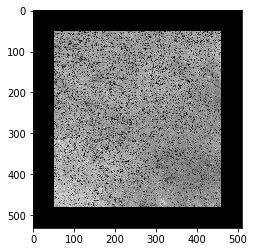

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [ ]:
# Define affine warp
